# Batch Document OCR with Deepseek-OCR & HF jobs

This notebook runs a three-stage OCR pipeline on Hugging Face Jobs:

1. **Extract** - Run DeepSeek OCR over a dataset, save Markdown and crop detected figures
2. **Describe** - Generate captions for extracted figures  
3. **Assemble** - Enrich Markdown with figure captions in a final markdown.

All three stages write to **a single HF dataset repository**. Each stage pulls the current dataset, adds new columns with its outputs, and pushes the updated dataset back.

## 📑 Table of Contents

1. [Setup](#setup)
   - [Hugging Face Jobs](#hf-jobs)
   - [The dataset](#dataset)
   - [Inference Backend: vLLM](#vllm-backend)
2. [Configuration](#configuration)
   - [DeepSeek-OCR Prompts](#prompts)
3. [Upload Pipeline Code](#upload-code)
4. [Helper Functions](#helpers)
5. [Stage 1: Extract](#stage-1)
   - [Batch size optimization](#batch-size)
6. [Stage 2: Describe](#stage-2)
7. [Stage 3: Assemble](#stage-3)
8. [Cost Analysis](#cost-analysis)


<a id="code-shipping"></a>
### 📦 How the pipeline code is shipped

For every HF Job we launch, the logic is similar:

**From this notebook**, we upload to a dataset repository on the Hub:
1. The entrypoint script (`hf_job_runner.py`)
2. The pipeline code in `llm_ocr/`

**Then we launch an HF Job** pointing to the entrypoint script stored in our dataset. The job:
1. Downloads the code from the dataset repository
2. Imports `llm_ocr.cli` and calls `main()` to run the requested pipeline stage


<a id="setup"></a>
## ⚙️ Setup

<a id="hf-jobs"></a>
### 🤗 Hugging Face Jobs

[HF Jobs](https://huggingface.co/docs/huggingface_hub/en/guides/jobs) run a command in a Docker image on Hugging Face-managed compute (CPU or GPU). You pick an image, a command, and a hardware flavor (e.g. `a100-large`). Jobs are pay-as-you-go.

> ⚠️ **Requirement**: HF Jobs are available for **PRO users** and members of **Team / Enterprise organizations**.

See: [HF Jobs guide](https://huggingface.co/docs/huggingface_hub/en/guides/jobs)


<a id="dataset"></a>
### 📚 The dataset 

This pipeline uses **FineVision** (`HuggingFaceM4/FineVision`) as a large, mixed **image+text** corpus for vision-language training/evaluation. FineVision aggregates many public sub-datasets into one unified interface, and you select a specific *subset/config* when loading.

- **Dataset**: [`HuggingFaceM4/FineVision`](https://huggingface.co/datasets/HuggingFaceM4/FineVision)
- **Overview / exploration space**: [`HuggingFaceM4/FineVision` Space](https://huggingface.co/spaces/HuggingFaceM4/FineVision)

#### The `olmOCR` subsets

The [`olmOCR-mix-0225`](https://arxiv.org/pdf/2502.18443) dataset from Allen AI contains **260,000 crawled PDF pages** from over 100,000 diverse PDFs - academic papers, legal documents, public domain books, brochures, and more. It includes challenging content: graphics, handwritten text, multi-column layouts, tables, equations, and poor quality scans.

Available configs:
- `olmOCR-mix-0225-documents` - general documents
- `olmOCR-mix-0225-books` - book pages

> 📄 **Note**: In this pipeline, **one document = one page** of a PDF.

These mirror real-world enterprise use cases: contracts, invoices, reports, forms, and scanned documents that organizations need to digitize and extract structured information from.

> **Licensing note**: FineVision is a *collection* of many datasets, each with its own license/terms. Make sure the subset you use is compatible with your intended downstream use (see the dataset card for details).

<a id="vllm-backend"></a>
### ⚡ Inference Backend: vLLM

This pipeline uses [**vLLM**](https://github.com/vllm-project/vllm) as the inference backend for DeepSeek-OCR. vLLM provides:

- **High throughput** via continuous batching and PagedAttention
- **OpenAI-compatible API** - easy to integrate with existing code
- **Efficient memory management** - run large models on limited GPU memory

The HF Job runs the [`vllm/vllm-openai:v0.12.0`](https://hub.docker.com/r/vllm/vllm-openai) Docker image, which starts a vLLM server. The pipeline sends batched requests (64 concurrent) to saturate the GPU and maximize throughput (~85 docs/min on A100).

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

--- Doc 0 ---


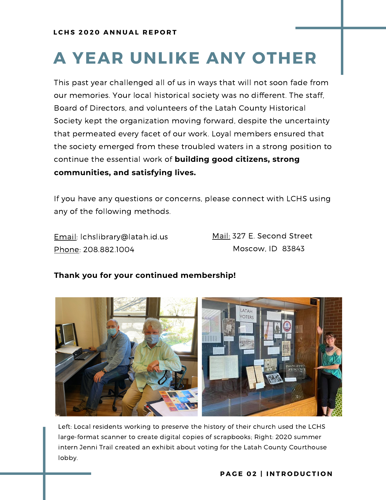

--- Doc 1 ---


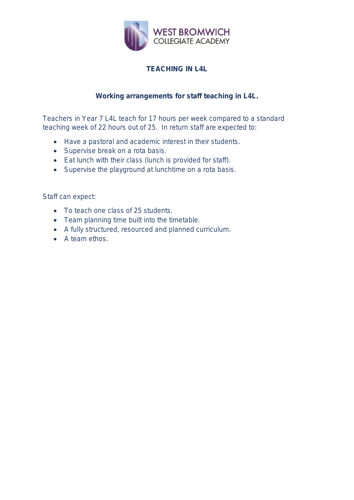

--- Doc 2 ---


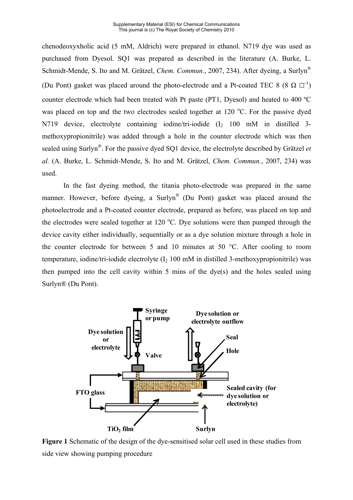

In [2]:
# Preview 3 random document images
from datasets import load_dataset
from itertools import islice
from IPython.display import display

ds = load_dataset("HuggingFaceM4/FineVision", "olmOCR-mix-0225-documents", split="train", streaming=True).shuffle(seed=123)
for i, s in enumerate(islice(ds, 3)):
    print(f"--- Doc {i} ---")
    img = s["images"][0]
    img.thumbnail((500, 500))  # Resize to max 400px
    display(img)

<a id="configuration"></a>
## ⚙️ Configuration

In [3]:
import os
import shutil
import tempfile
import time
from pathlib import Path

from huggingface_hub import HfApi, create_repo, fetch_job_logs, inspect_job, run_uv_job, whoami
from huggingface_hub._jobs_api import JobInfo, JobStage

In [4]:
# 🔑 Authenticate with Hugging Face
# Required for accessing private datasets and pushing results
# Get your token at: https://huggingface.co/settings/tokens
import os
from huggingface_hub import login, get_token

login()

# Store token in env var for HF Jobs
os.environ["HF_TOKEN"] = get_token()
print(f"HF_TOKEN set: {os.environ['HF_TOKEN'][:8]}...")


HF_TOKEN set: hf_MICph...


In [ ]:
# Configuration
USERNAME = whoami()["name"]
HUB_IMAGE = "vllm/vllm-openai:v0.12.0"  # GPU stages (extract, describe)
LIGHTWEIGHT_IMAGE = "python:3.12-slim"  # CPU-only stages (assemble) - much smaller
HARDWARE_GPU = "a100-large"
HARDWARE_CPU = "cpu-upgrade"
TIMEOUT = "3h"

# Code and data repos
CODE_REPO = f"{USERNAME}/ocr-job-code"
DATASET_REPO = f"{USERNAME}/finevision-olmocr-processed"

# Source dataset
SOURCE_DATASET = "HuggingFaceM4/FineVision"
SOURCE_CONFIG = "olmOCR-mix-0225-documents"
MAX_SAMPLES =  1024 #total number of samples to process

print(f"Code: {CODE_REPO} | Dataset: {DATASET_REPO}")
print(f"Source: {SOURCE_DATASET}/{SOURCE_CONFIG} ({MAX_SAMPLES} samples)")

Code: florentgbelidji/ocr-job-code | Dataset: florentgbelidji/finevision-olmocr-processed
Source: HuggingFaceM4/FineVision/olmOCR-mix-0225-documents (256 samples)


<a id="prompts"></a>
### 📝 DeepSeek-OCR Prompts

DeepSeek-OCR supports different prompts for various OCR tasks. See the [official config.py](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py) for examples:

| Use Case | Prompt |
|----------|--------|
| **Document → Markdown** | `<image>\n<\|grounding\|>Convert the document to markdown.` |
| **General OCR** | `<image>\n<\|grounding\|>OCR this image.` |
| **Free OCR (no layout)** | `<image>\nFree OCR.` |
| **Parse figures** | `<image>\nParse the figure.` |
| **Describe image** | `<image>\nDescribe this image in detail.` |
| **Locate text** | `<image>\nLocate <\|ref\|>text<\|/ref\|> in the image.` |

The `<|grounding|>` token enables bounding box detection for figures and layout elements.

We configure these prompts via environment variables `DOC_PROMPT` and `FIGURE_PROMPT` in our job configuration, re-using the special tokens from the [official DeepSeek-OCR config](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py).


In [6]:
# Base environment for all stages
BASE_ENV = {
    # vLLM
    "MODEL_ID": "deepseek-ai/DeepSeek-OCR",
    "SERVED_MODEL_NAME": "deepseek-ocr",
    "HOST": "0.0.0.0",
    "PORT": "8000",
    "MAX_MODEL_LEN": "8192",
    "GPU_MEMORY_UTILIZATION": "0.90",
    "TENSOR_PARALLEL_SIZE": "1", #number of GPUs to use
    # Code
    "JOB_CODE_REPO": CODE_REPO,
    "JOB_CODE_REVISION": "main",
    "JOB_CODE_LOCAL_DIR": "/tmp/deepseek-ocr-job-code",
    # Auth - HF_TOKEN is passed as a secret (encrypted), not in env
    # Prompts
    "DOC_PROMPT": "<image>\n<|grounding|>Convert this document to Markdown.",
    "DOC_MAX_TOKENS": "4096",
    "DOC_TEMPERATURE": "0.1",
    "FIGURE_PROMPT": "<image>\nDescribe this image in detail.",
    "FIGURE_MAX_TOKENS": "512",
    "FIGURE_TEMPERATURE": "0.6",
}

<a id="upload-code"></a>
## 📤 Upload Pipeline Code

In [7]:
# Upload code to HF Hub
CODE_PATHS = [
    Path("hf_job_runner.py"),
    Path("../llm_ocr"),
]

api = HfApi()
create_repo(repo_id=CODE_REPO, repo_type="dataset", exist_ok=True)
create_repo(repo_id=DATASET_REPO, repo_type="dataset", exist_ok=True)

bundle_dir = Path(tempfile.mkdtemp(prefix="job-code-"))
for path in CODE_PATHS:
    src = Path.cwd() / path if not path.is_absolute() else path
    if src.is_dir():
        shutil.copytree(src, bundle_dir / path.name, dirs_exist_ok=True)
    else:
        shutil.copy2(src, bundle_dir / path.name)

api.upload_folder(folder_path=str(bundle_dir), repo_id=CODE_REPO, repo_type="dataset")
print(f"Uploaded code to {CODE_REPO}")
print(f"Code repo: https://huggingface.co/datasets/{CODE_REPO}")

Uploaded code to florentgbelidji/ocr-job-code
Code repo: https://huggingface.co/datasets/florentgbelidji/ocr-job-code


<a id="helpers"></a>
## 🛠️ Helper Functions

In [9]:
# Helper functions
CODE_URL = f"https://huggingface.co/datasets/{CODE_REPO}/resolve/main/hf_job_runner.py"

#launch job function
def launch(stage: str, flavor: str, env: dict, image: str = None) -> JobInfo:
    full_env = {**BASE_ENV, **env, "PIPELINE_STAGE": stage}
    # Pass HF_TOKEN as a secret (encrypted server-side) for security
    secrets = {"HF_TOKEN": os.environ.get("HF_TOKEN")}
    job = run_uv_job(CODE_URL, image=image or HUB_IMAGE, flavor=flavor, env=full_env, secrets=secrets, timeout=TIMEOUT)
    print(f"Launched {stage}: {job.url}")
    return job

#wait for job to complete
def wait(job: JobInfo, poll: int = 60) -> JobInfo:
    while True:
        info = inspect_job(job_id=job.id)
        stage = info.status.stage
        print(f"  {job.id}: {stage}")
        if stage not in {JobStage.RUNNING, "RUNNING", "UPDATING"}:
            return info
        time.sleep(poll)

#print job logs
def logs(job: JobInfo, tail: int = 100):
    for line in list(fetch_job_logs(job_id=job.id, namespace=job.owner.name))[-tail:]:
        print(line, end="")


# Import rendering utilities from llm_ocr
import sys; sys.path.insert(0, "..")
from llm_ocr.document import render_sample_markdown, display_markdown, display_samples

<a id="stage-1"></a>
## 🔍 Stage 1: Extract

Run DeepSeek OCR on each document image to produce Markdown and extract figure crops. This stage runs on GPU.

![Extract Stage Pipeline](../assets/extract-hf.png)

<a id="batch-size"></a>
### How to set up batch size for efficient processing

Since we're running **batch inference** (not serving live users), we can aggressively maximize GPU utilization without worrying about latency SLAs. The goal is to keep the GPU fully saturated by maintaining enough concurrent requests in flight.

**Understanding vLLM's KV cache capacity**

vLLM allocates GPU memory for its KV cache, which determines how many concurrent requests can be processed. When vLLM starts, it calculates and logs the KV cache capacity for your specific GPU:

```
INFO [kv_cache_utils.py] GPU KV cache size: 1,115,616 tokens
INFO [kv_cache_utils.py] Maximum concurrency for 8,192 tokens per request: 136.18x
```

Check your job logs to find these values for your hardware. The maximum concurrency depends on:

```
max_concurrency = KV_cache_tokens / tokens_per_request
```

For a sizing length of **8,192 total tokens** (prompt + generated), typical capacities are:

| GPU | KV Cache Tokens | Hard Cap | Safe Target (70-85%) |
|-----|-----------------|----------|----------------------|
| **A100** (80GB) | ~1,115,616 | 136 | **100-120** |

**Setting safe concurrency**

The `EXTRACT_BATCH_SIZE` parameter controls concurrent requests sent to vLLM. To set it safely:

1. **Estimate total tokens per request**: `L_total = prompt_tokens + generated_tokens`. For OCR, generated markdown can be substantial - use your **p95** (not average) to avoid preemption.
2. **Apply 70-85% headroom**: This accounts for variance in document lengths and prevents KV cache pressure.
3. **If most docs are well below 8,192 tokens**, you can push higher concurrency.

**Our dataset: 1 page = 1 request**

In this pipeline, each request processes a **single PDF page**, which typically produces far fewer tokens than the 8,192 sizing length. This allows us to push concurrency well beyond the conservative estimates above.

For this pipeline running on **A100 GPUs**, we use **256 concurrent requests** - nearly 2x the theoretical hard cap - because actual token usage per page is much lower.

In [11]:
# Stage 1: Extract
stage1 = launch("extract", flavor=HARDWARE_GPU, env={
    "DATASET_NAME": SOURCE_DATASET,
    "DATASET_CONFIG": SOURCE_CONFIG,
    "DATASET_SPLIT": "train",
    "MAX_SAMPLES": str(MAX_SAMPLES),
    "OUTPUT_DIR": "./outputs",
    "EXTRACT_BATCH_SIZE": "256", #concurrent requests that form a batch
    "HF_REPO_ID": DATASET_REPO,
})


Launched extract: https://huggingface.co/jobs/florentgbelidji/69690edd5879a7164c034b34


/opt/pytorch/lib/python3.12/site-packages/huggingface_hub/utils/_experimental.py:60: UserWarning: 'HfApi.run_uv_job' is experimental and might be subject to breaking changes in the future without prior notice. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(


In [12]:
stage1_done = wait(stage1)
print(f"Extract complete: {DATASET_REPO}")
print(f"Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: RUNNING
  69690edd5879a7164c034b34: COMPLETED
Extract complete: florentgbelidji/finevision-olmocr-processed
Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


README.md:   0%|          | 0.00/614 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset: 255 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


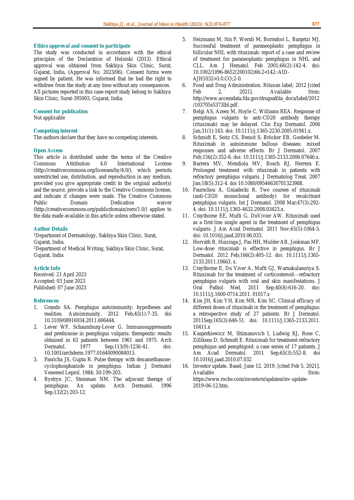


Markdown preview (4750 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


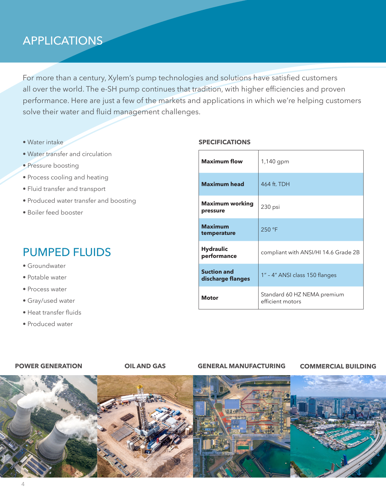


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


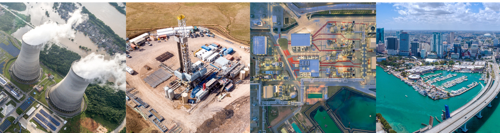

In [13]:
# Load and display samples after Extract
from datasets import load_dataset

ds_extract = load_dataset(DATASET_REPO, split="train")
display_samples(ds_extract, num_samples=2)

<a id="stage-2"></a>
## 🏷️ Stage 2: Describe

Generate captions for each extracted figure using vision-language inference.

![Describe Stage Pipeline](../assets/describe-hf.png)

In [14]:
# Stage 2: Describe
# Updates dataset in place (same repo)
stage2 = launch("describe", flavor=HARDWARE_GPU, env={
    "OUTPUT_DIR": "./outputs",
    "DESCRIBE_BATCH_SIZE": "32",
    "SOURCE_REPO_ID": DATASET_REPO,
    "HF_REPO_ID": DATASET_REPO,
})


Launched describe: https://huggingface.co/jobs/florentgbelidji/6969105a15f6de8b7dfb26f4


In [15]:
stage2_done = wait(stage2)
print(f"Describe complete: {DATASET_REPO}")
print(f"Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  6969105a15f6de8b7dfb26f4: RUNNING
  6969105a15f6de8b7dfb26f4: RUNNING
  6969105a15f6de8b7dfb26f4: RUNNING
  6969105a15f6de8b7dfb26f4: RUNNING
  6969105a15f6de8b7dfb26f4: COMPLETED
Describe complete: florentgbelidji/finevision-olmocr-processed
Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


Dataset: 255 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


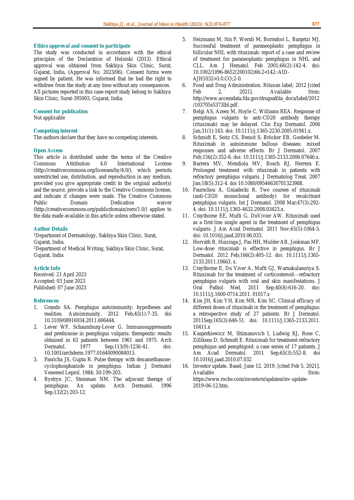


Markdown preview (4750 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


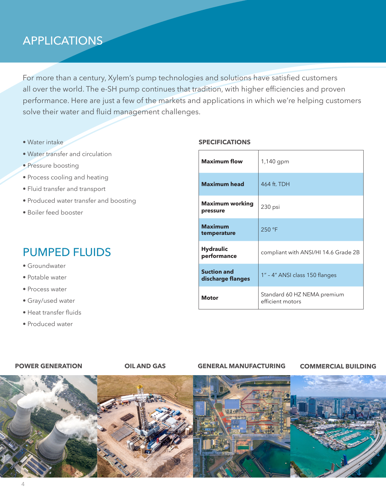


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


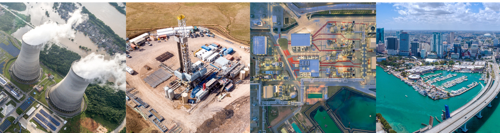

  📝 Description: The figure provided showcases three distinct images, each representing a different type of data. The images are labeled as "Air," "Oil," and "Water," respectively. Here is a detailed description of ea...



In [19]:

from datasets import load_dataset
# Load and display samples after Describe
ds_describe = load_dataset(DATASET_REPO, split="train")
display_samples(ds_describe, num_samples=2)

<a id="stage-3"></a>
## 🧩 Stage 3: Assemble

Combine the original Markdown with figure captions to produce the final enriched document. This stage runs **CPU-only** with a lightweight Docker image (`python:3.12-slim`) - no vLLM or PyTorch needed.

> 💡 Uses `LIGHTWEIGHT_IMAGE` instead of the full vLLM image, significantly reducing startup time and costs.

![Assemble Stage Pipeline](../assets/assemble-hf.png)


In [21]:
# Stage 3: Assemble
# Updates dataset in place + saves final markdown files
stage3 = launch("assemble", flavor=HARDWARE_CPU, image=LIGHTWEIGHT_IMAGE, env={
    "OUTPUT_DIR": "./outputs",
    "SOURCE_REPO_ID": DATASET_REPO,
    "HF_REPO_ID": DATASET_REPO,
    "HF_COMMIT_MESSAGE": "Add assembled documents with figure captions",
})


Launched assemble: https://huggingface.co/jobs/florentgbelidji/696918de15f6de8b7dfb26f9


In [22]:
stage3_done = wait(stage3)
print(f"Pipeline complete! Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  696918de15f6de8b7dfb26f9: RUNNING
  696918de15f6de8b7dfb26f9: ERROR
Pipeline complete! Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


Dataset: 255 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


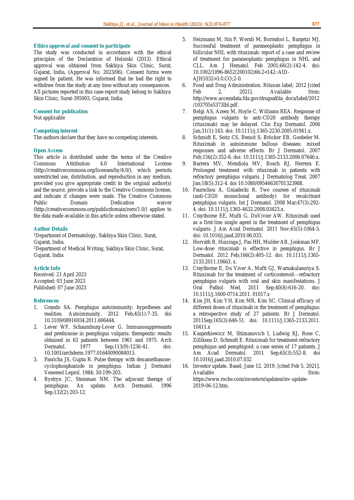


Markdown preview (4750 chars):
## Ethics approval and consent to participate  

The study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to Sakhiya Skin Clinic, Surat- 395003, Gujarat...

=== Sample 1: sample_00001 ===
Source image:


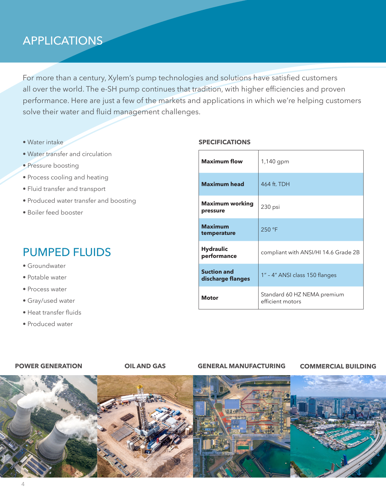


Markdown preview (1218 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tr...

Extracted figures: 1


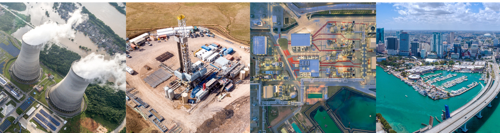

  📝 Description: The figure provided showcases three distinct images, each representing a different type of data. The images are labeled as "Air," "Oil," and "Water," respectively. Here is a detailed description of ea...



In [23]:
# Load and display final samples after Assemble
ds_final = load_dataset(DATASET_REPO, split="train")
display_samples(ds_final, num_samples=2)

# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

- Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water transfer and boosting- Boiler feed booster  

## PUMPED FLUIDS  

- Groundwater- Potable water- Process water- Gray/used water- Heat transfer fluids- Produced water  

## SPECIFICATIONS  

<table><tr><td>Maximum flow</td><td>1,140 gpm</td></tr><tr><td>Maximum head</td><td>464 ft. TDH</td></tr><tr><td>Maximum working pressure</td><td>230 psi</td></tr><tr><td>Maximum temperature</td><td>250 °F</td></tr><tr><td>Hydraulic performance</td><td>compliant with ANSI/HI 14.6 Grade 2B</td></tr><tr><td>Suction and discharge flanges</td><td>1&quot; - 4&quot; ANSI class 150 flanges</td></tr><tr><td>Motor</td><td>Standard 60 HZ NEMA premium efficient motors</td></tr></table>  

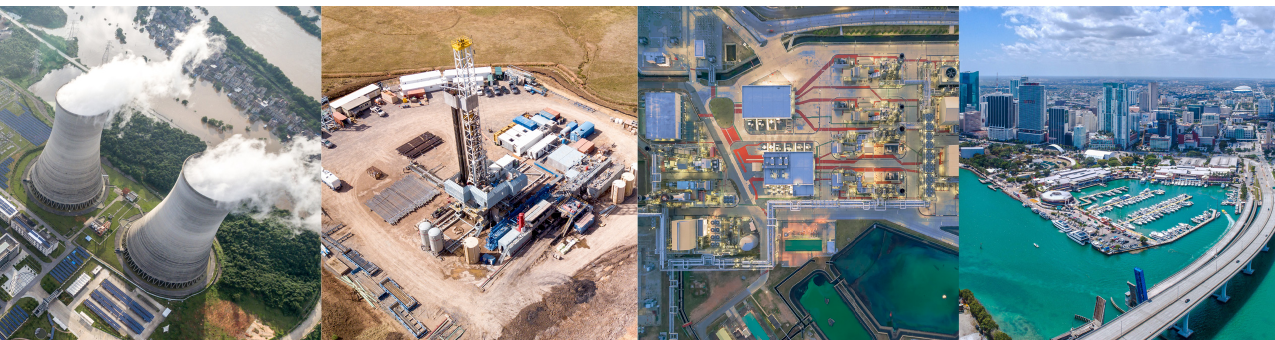

In [24]:
# Display rendered markdown with images for sample 1
# This properly renders figure: URIs using images from extracted_figures column
display_markdown(ds_final[1])

<a id="cost-analysis"></a>
## 💰 Cost Analysis (Extract stage only)

| Metric | Value |
|--------|-------|
| 🖥️ **Hardware** | Nvidia A100 (80GB) |
| ⚡ **Throughput** | ~91 pages/min |
| 🔄 **Concurrency** | 128 parallel requests (saturates GPU batch) |
| 💵 **Hourly rate** | [$2.50/hour](https://huggingface.co/pricing) |

| Scale | ⏱️ Time | 💲 Cost |
|-------|------|------|
| 1,000 pages | ~11 min | ~$0.46 |
| 10,000 pages | ~1.8 hours | ~$4.60 |
| 100,000 pages | ~18 hours | ~$46 |

> 📄 **Note**: 1 page = 1 PDF page in these benchmarks.

> 💡 **Cost optimization**: These costs can be further optimized by evaluating the best instance type and hardware utilization based on your dataset characteristics (average page complexity, token lengths, batch sizes). Smaller GPUs like L4 may offer better cost-efficiency for simpler documents.